## Computer Vision - Homework 3

### Questions

Ex 2.9: White point balancing—tricky. A common (in-camera or post-processing) technique
for performing white point adjustment is to take a picture of a white piece of paper and
to adjust the RGB values of an image to make this a neutral color.

Q: Describe how you would adjust the RGB values in an image given a sample “white
color” of (Rw;Gw;Bw) to make this color neutral (without changing the exposure too
much).

A: For adjusting RGB values given a sample "white color" (Rw,Gw,Bw):
  - The goal is to make this color neutral, meaning Rw=Gw=Bw
  - We should preserve overall brightness, which means keeping the luminance similar
  - A common approach is to scale each channel so that: R' = R*(1/Rw), G' = G*(1/Gw), B' = B*(1/Bw)
  - This makes the white reference point map to (1,1,1)

Q: Does your transformation involve a simple (per-channel) scaling of the RGB values or
do you need a full 3 3 color twist matrix (or something else)?

  A: For RGB Transformation:
  - The above solution uses simple per-channel scaling (diagonal matrix)
  - This is computationally efficient and widely used in cameras
  - The transformation matrix would be:
  ```
  | 1/Rw   0    0   |
  |  0    1/Gw   0  |
  |  0     0   1/Bw |
  ```

Q: Convert your RGB values to XYZ. Does the appropriate correction now only depend
on the XY (or xy) values? If so, when you convert back to RGB space, do you need a
full 3 3 color twist matrix to achieve the same effect?

  A: Converting to XYZ space:
  - When we convert to XYZ, the white point coordinates do reduce to just xy chromaticity 
  - However, to achieve the same correction when converting back to RGB, we would need a full 3x3 color twist matrix
  - This is because the RGB->XYZ->RGB transformation pathway, even for simple diagonal RGB scaling, results in cross-talk between channels

Q: If you used pure diagonal scaling in the direct RGB mode but end up with a twist if you
work in XYZ space, how do you explain this apparent dichotomy? Which approach is
correct? (Or is it possible that neither approach is actually correct?)

  A: Explaining the dichotomy:
  - The diagonal RGB scaling approach is simpler but makes assumptions about color space independence
  - The XYZ approach with full matrix transformation is more physically accurate as it accounts for:
    * Spectral overlap between RGB channels
    * Non-linear relationships in human color perception
    * Cross-talk between channels
  - Neither approach is "perfectly correct" because:
    * Real-world illumination has complex spectral distributions
    * Camera sensors have non-ideal spectral responses
    * Both methods are approximations of the true color adaptation process

  The diagonal RGB scaling is widely used because:
  - It's computationally efficient
  - Produces visually acceptable results in most cases
  - Easy to implement in-camera
  - Intuitive to understand and adjust

  The XYZ approach with full matrix transformation is more physically accurate but:
  - More computationally intensive
  - May produce unexpected results in edge cases
  - Harder to implement and tune

  In practice, the choice between methods often depends on the specific application:
  - Consumer cameras typically use diagonal RGB scaling
  - High-end color management systems might use full matrix transformations
  - Some advanced systems use hybrid approaches

  The key insight is that color adaptation is a complex process that we're approximating with simplified mathematical models - both approaches have their merits and limitations depending on the specific use case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from typing import Optional, List
import os
import detect
from typing import List, NamedTuple, Tuple
import torch
from torchvision import transforms
from PIL import Image
from collections import deque
import requests
import zipfile
from skimage import measure
from scipy import ndimage
import random
from torchvision.datasets import CelebA
from matplotlib.gridspec import GridSpec
import cv2
from tqdm import tqdm

### Utils functions

In [2]:
def get_celeba_dataset(root_dir="celeba_data"):
    """
    Download CelebA dataset using torchvision
    
    Parameters:
    root_dir (str): Directory to store the dataset
    """
    print("Downloading CelebA dataset...")
    
    # Create transforms
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    # Download and load dataset
    dataset = CelebA(root=root_dir, 
                    split='train',
                    transform=transform,
                    download=True)
    
    return dataset

def display_sample_images(dataset, num_images=16, num_cols=4):
    """
    Display random sample images from the dataset
    
    Parameters:
    dataset: CelebA dataset
    num_images (int): Number of images to display
    num_cols (int): Number of columns in the grid
    """
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 3*num_rows))
    
    for idx, img_idx in enumerate(indices):
        img_tensor, _ = dataset[img_idx]
        
        plt.subplot(num_rows, num_cols, idx + 1)
        
        # Convert tensor to numpy array and transpose to correct format
        img_array = img_tensor.permute(1, 2, 0).numpy()
        
        # Clip values to [0, 1] range
        img_array = np.clip(img_array, 0, 1)
        
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f'Image {idx + 1}')
    
    plt.tight_layout()
    plt.show()

### Visualize the images

Files already downloaded and verified


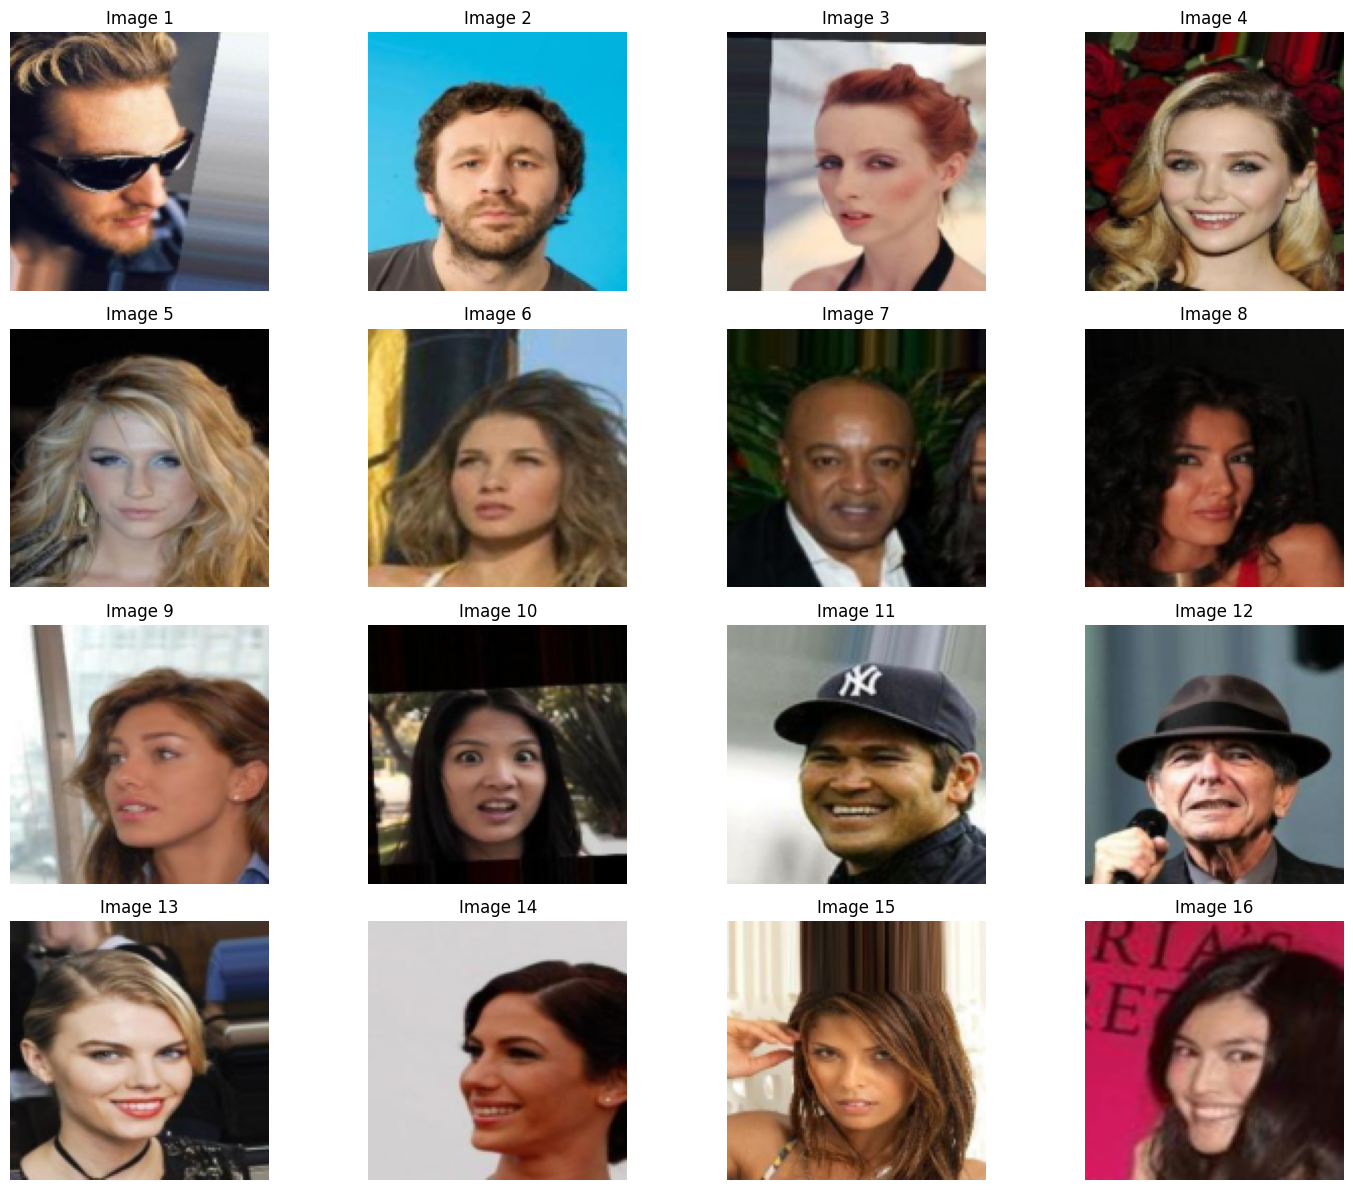

In [5]:
# %pip install gdown
try:
    # Download and load dataset
    dataset = get_celeba_dataset()

    # Display sample images
    display_sample_images(dataset)
        
except Exception as e:
    print(f"Error: {str(e)}")

### Hue Processing

In [65]:
def tensor_to_rgb(tensor):
    """Convert tensor to RGB numpy array"""
    return (tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

def make_hsv(img):
    """Convert RGB image to HSV"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def analyze_hue_distribution(dataset, num_images=4, intervals_num=6):
    """
    Analyze hue distribution of images from the dataset
    
    Parameters:
    dataset: CelebA dataset
    num_images: Number of images to analyze
    intervals_num: Number of hue intervals to display
    """
    # Get random images from dataset
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # Create figure with custom grid
    fig = plt.figure(figsize=(22, 5*num_images))
    gs = GridSpec(num_images, 2 + intervals_num, 
                 width_ratios=[1, 2] + [1]*intervals_num,
                 figure=fig)
    
    for row, idx in enumerate(indices):
        # Get image
        img_tensor, _ = dataset[idx]
        img_rgb = tensor_to_rgb(img_tensor)
        
        # Convert to HSV
        hsv = make_hsv(img_rgb)
        hues = hsv[:, :, 0]
        
        # Plot original image
        ax = fig.add_subplot(gs[row, 0])
        ax.imshow(img_rgb)
        ax.axis('off')
        if row == 0:
            ax.set_title('Original image')
        
        # Plot hue histogram
        ax = fig.add_subplot(gs[row, 1])
        ax.hist(hues[hues <= 18].reshape(-1), bins=50, color='blue', alpha=0.7)
        ax.set_title('Hue histogram (0-18)' if row == 0 else '')
        ax.set_xlabel('Hue value')
        ax.set_ylabel('Frequency')
        
        # Plot hue interval masks
        bounds = np.linspace(2, 10, intervals_num)
        for j, (l, r) in enumerate(zip(bounds, bounds + 4)):
            ax = fig.add_subplot(gs[row, 2 + j])
            mask = (l <= hues) & (hues <= r)
            ax.imshow(mask, cmap='gray')
            ax.axis('off')
            if row == 0:
                ax.set_title(f'Hue [{l:.2f}, {r:.2f}]')
    
    plt.tight_layout()
    plt.show()

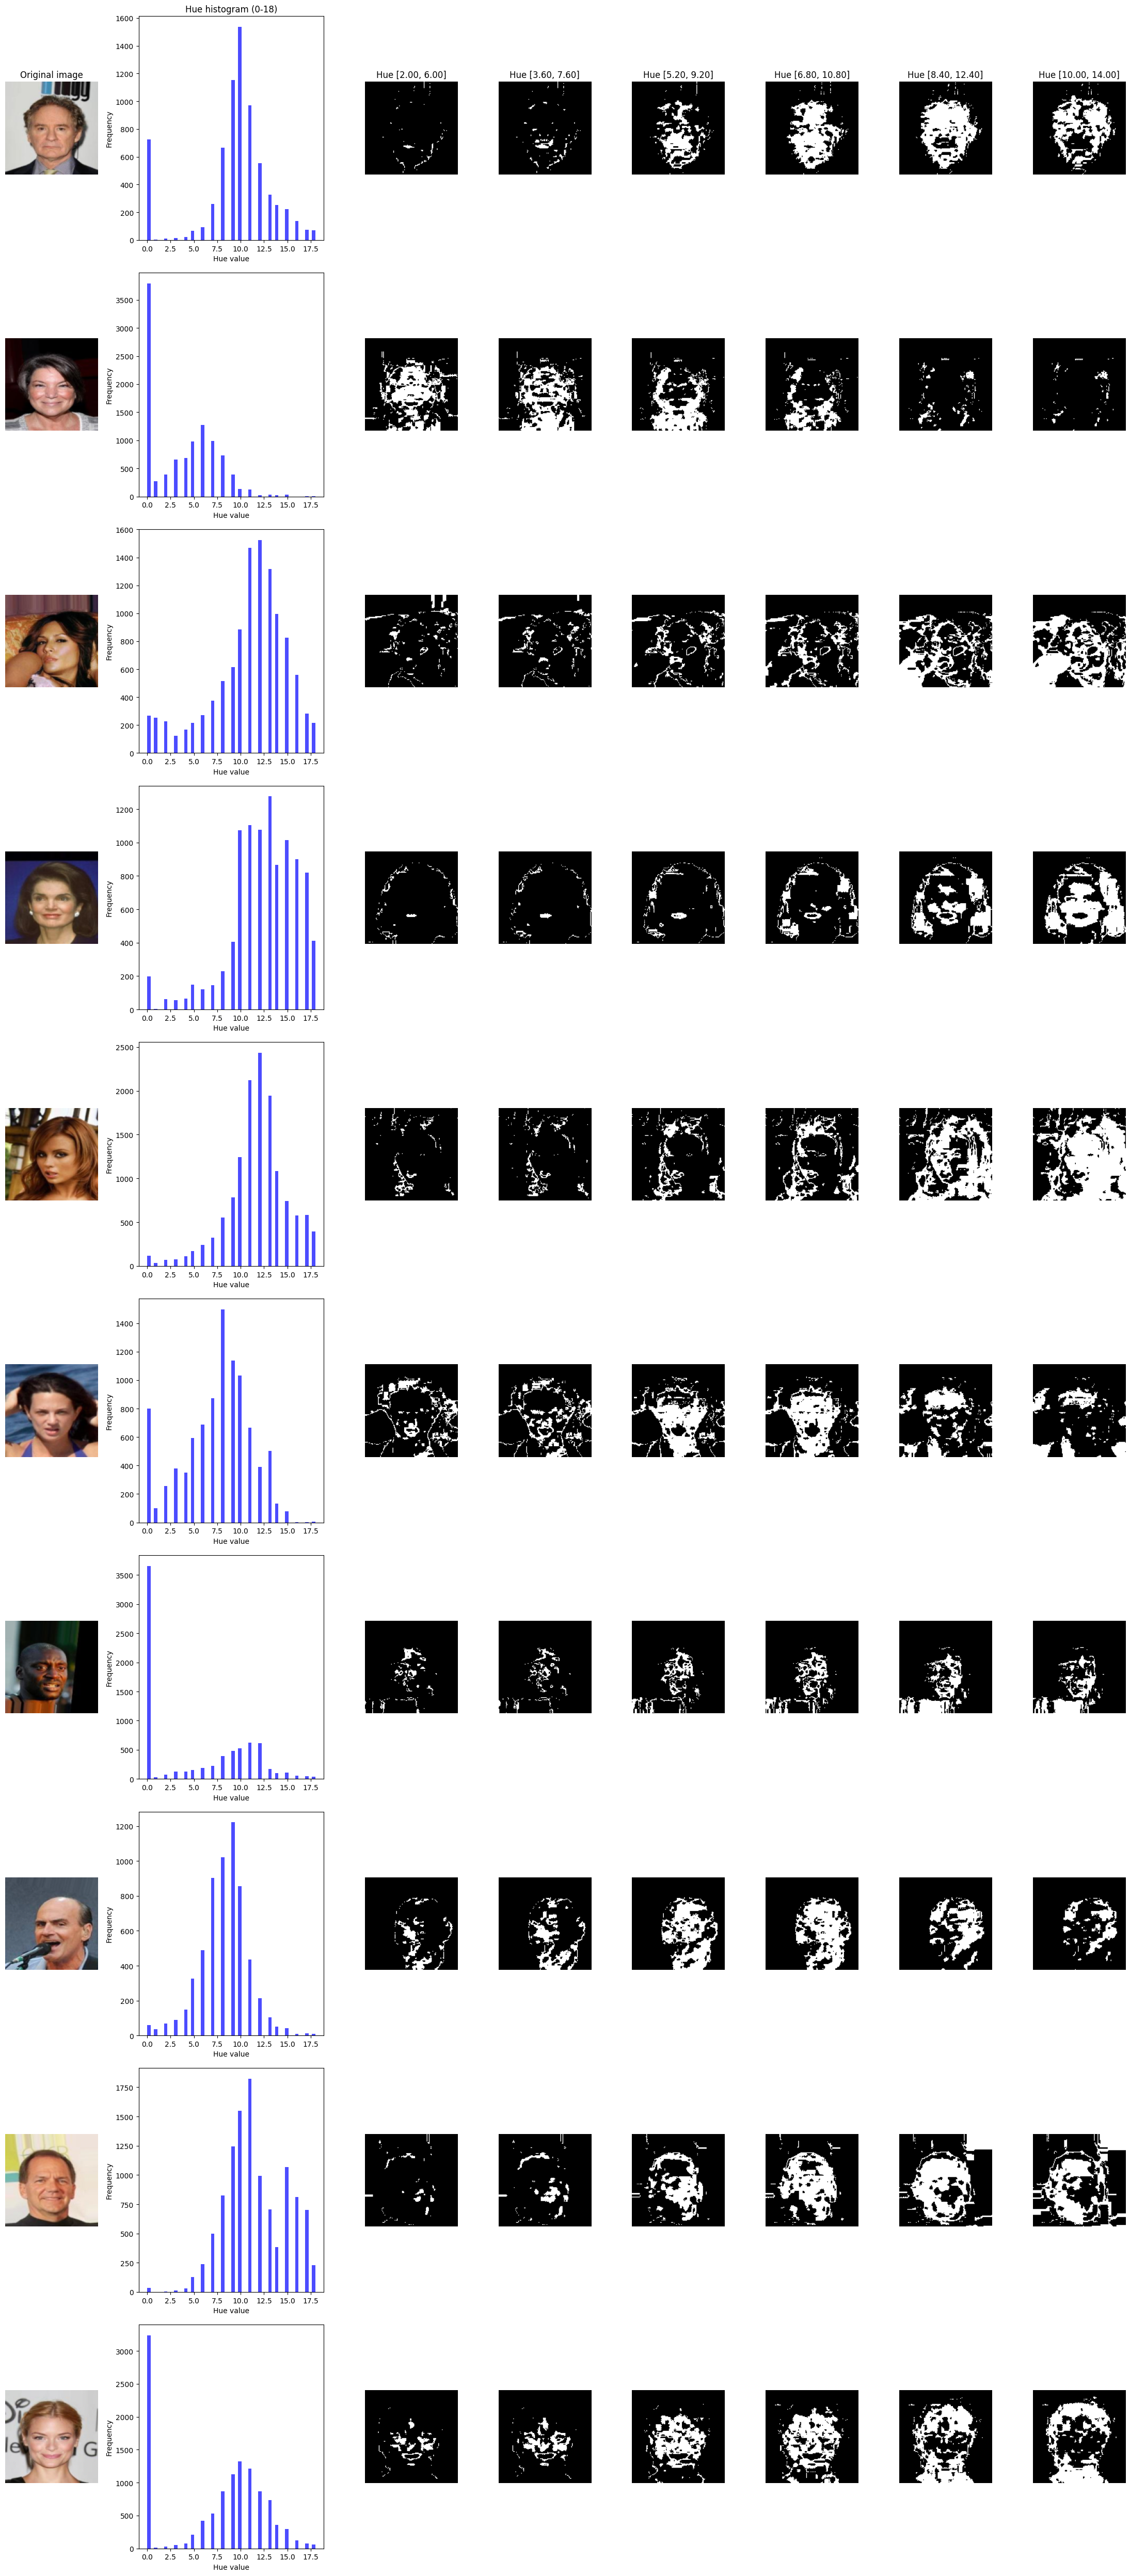

In [66]:
try:
    # Analyze hue distribution
    analyze_hue_distribution(dataset, num_images=10, intervals_num=6)

except Exception as e:
    print(f"Error: {str(e)}")

In [59]:
def tensor_to_rgb(tensor):
    """Convert tensor to RGB numpy array"""
    return (tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

def make_hsv(img):
    """Convert RGB image to HSV"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def analyze_normalized_hue(dataset, num_images=4):
    """
    Analyze normalized hue distribution of images from the dataset
    with overlapping intervals
    """
    INTERVALS_NUM = 6
    
    # Get random images from dataset
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # Create figure
    fig, ax = plt.subplots(num_images, 2 + INTERVALS_NUM,
        gridspec_kw={
            'width_ratios': [1, 2]+[1]*INTERVALS_NUM,
        })
    fig.set_figheight(22)
    fig.set_figwidth(22)
    
    for i, idx in enumerate(indices):
        # Get and process image
        img_tensor, _ = dataset[idx]
        img_rgb = tensor_to_rgb(img_tensor)
        
        # Display original image
        ax[i, 0].imshow(img_rgb)
        ax[i, 0].axis('off')
        ax[0, 0].set_title('Original image')
        
        # Process hue
        hsv = make_hsv(img_rgb)
        hues = hsv[:, :, 0]
        hues = hues / hues.max()  # Normalize hues
        
        # Plot histogram
        ax[i, 1].hist(hues.reshape(-1), bins=50)
        ax[0, 1].set_title('Hue histogram')
        
        # Plot overlapping hue interval masks
        bounds = np.linspace(0.00, 0.08, INTERVALS_NUM)  # This gives [0.00, 0.016, 0.032, 0.048, 0.064, 0.08]
        for j, l in enumerate(bounds):
            r = l + 0.04  # Each interval is 0.04 wide
            mask = (l <= hues) & (hues <= r)
            ax[i, 2 + j].imshow(mask, cmap='gray')
            ax[i, 2 + j].axis('off')
            ax[0, 2 + j].set_title(f'Hue [{l:.2f}, {r:.2f}]')
    
    plt.tight_layout()
    plt.show()

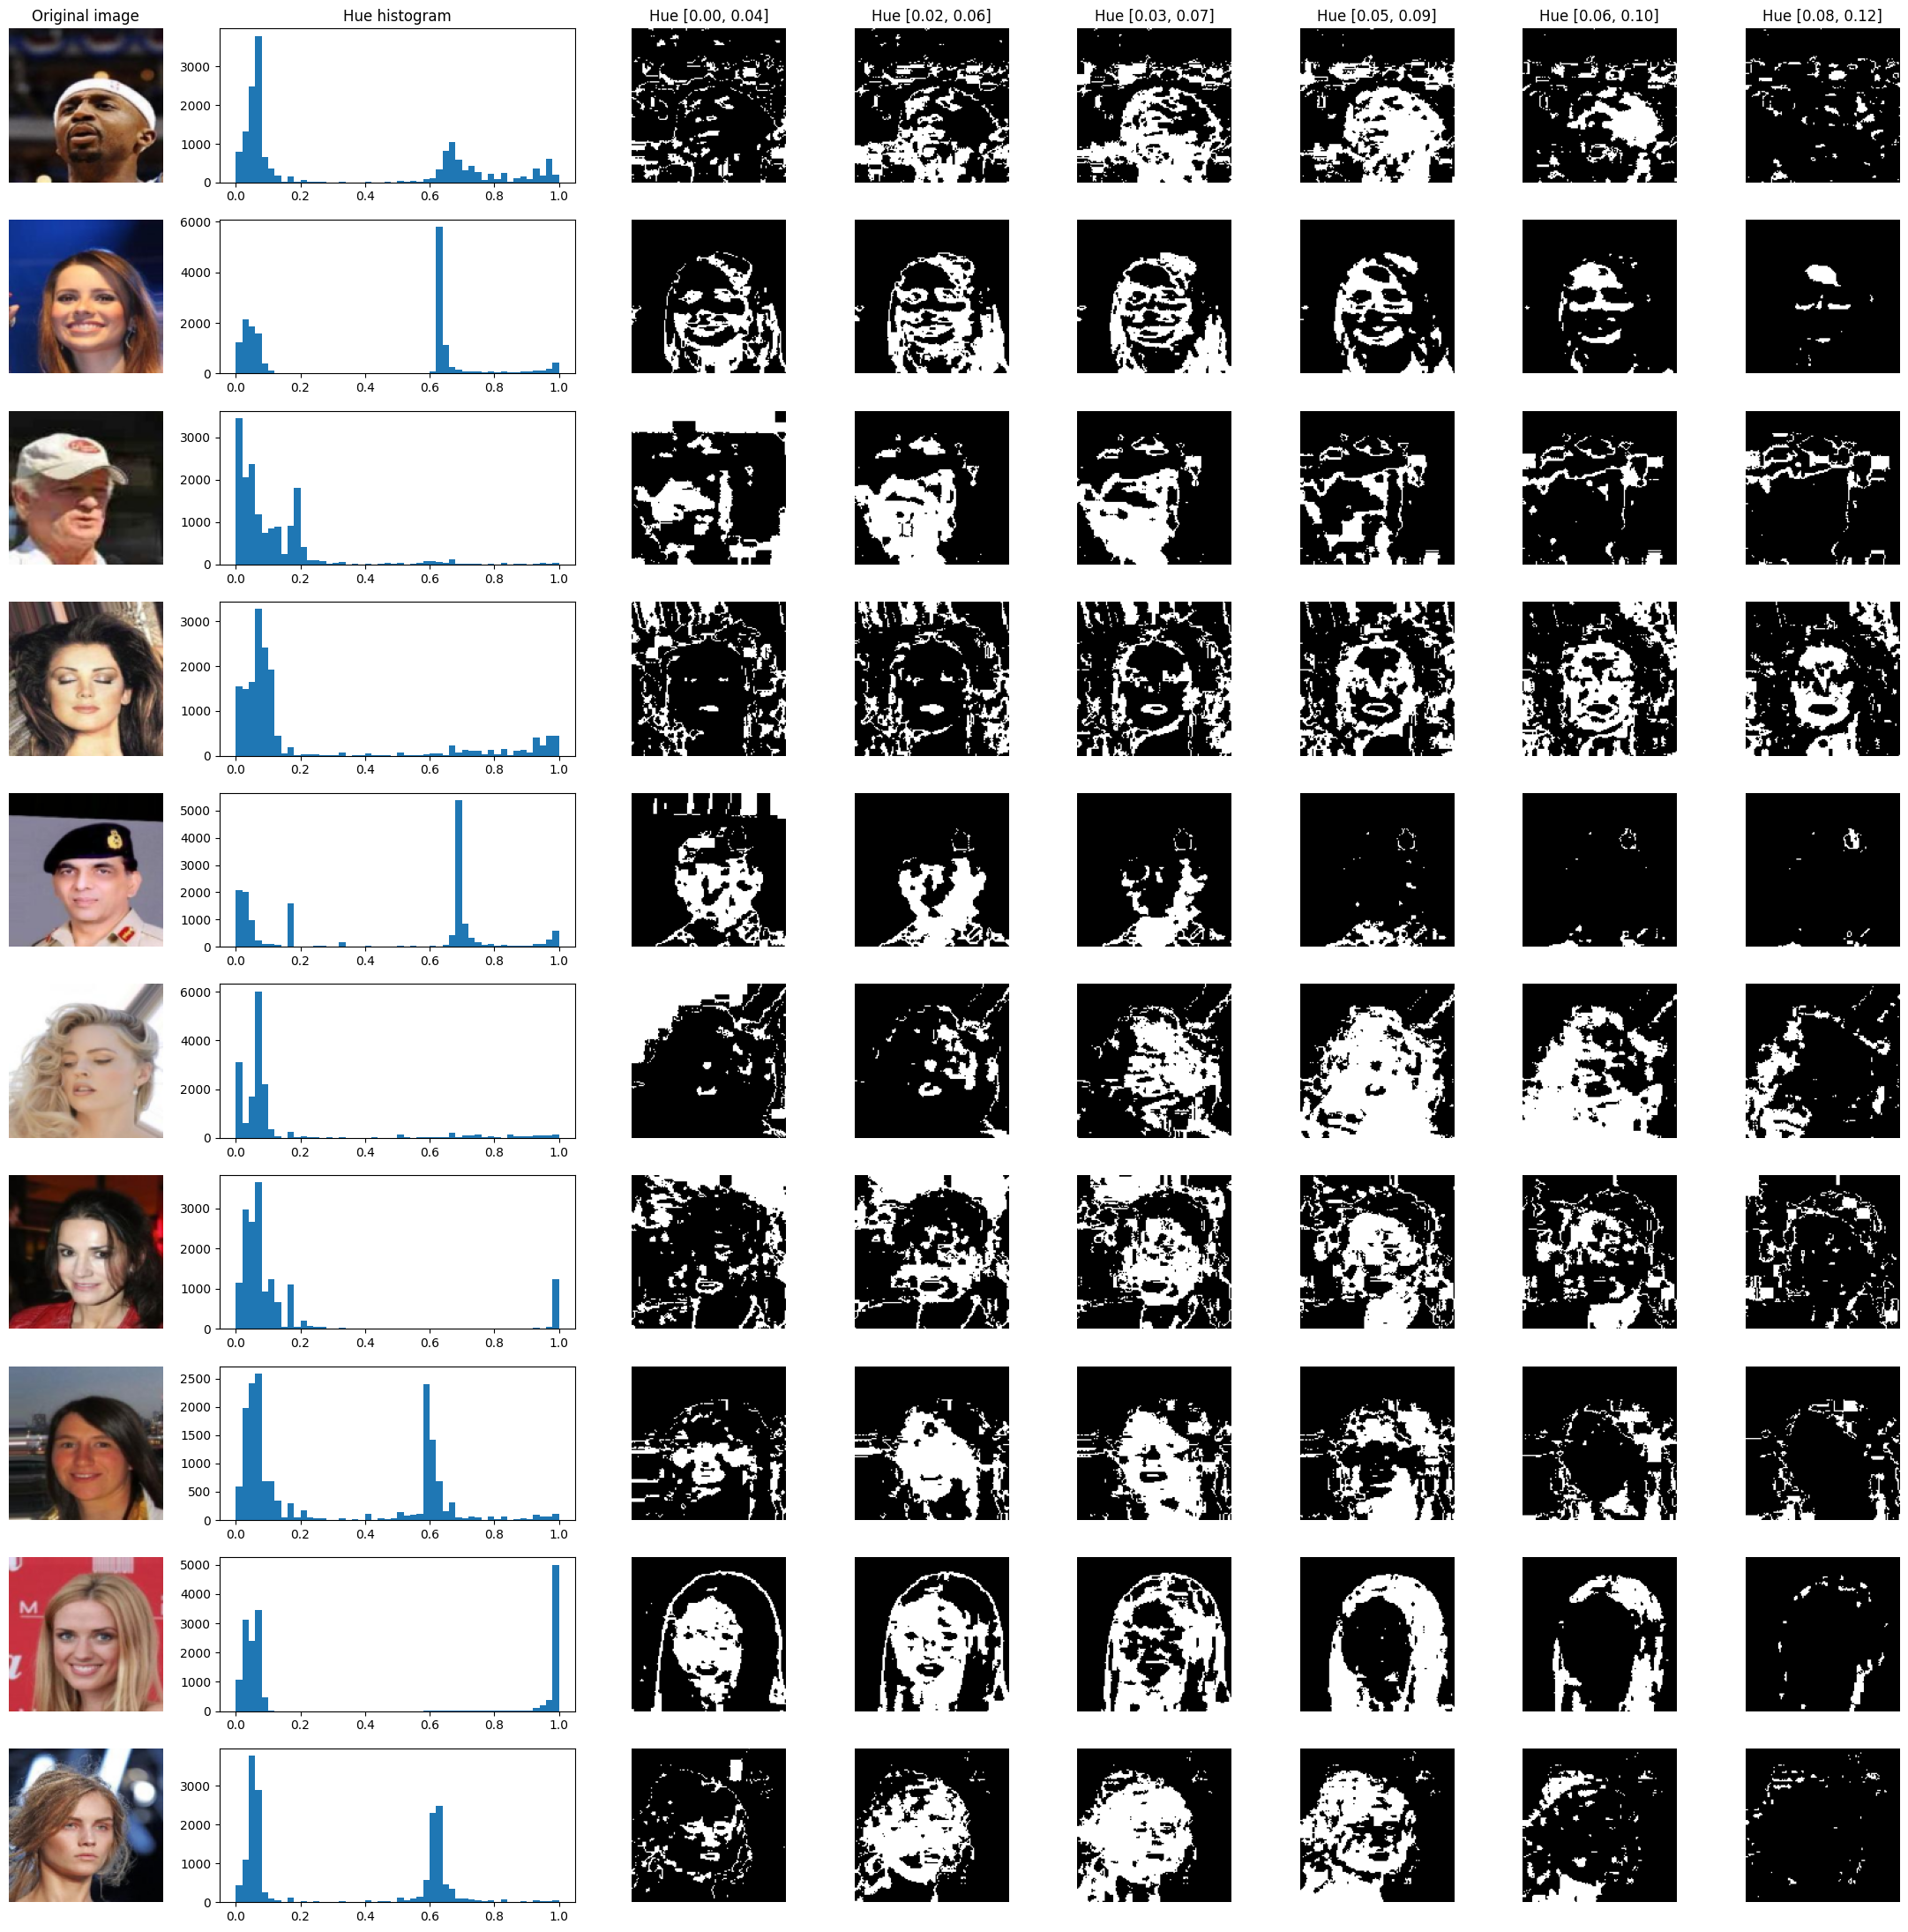

In [63]:
try:
    # Analyze hue distribution
    analyze_normalized_hue(dataset, num_images=10)

except Exception as e:
    print(f"Error: {str(e)}")

### Connected Components

In [97]:
def make_hsv(img: np.ndarray) -> np.ndarray:
    """Convert RGB image to HSV"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def make_bw(img: np.ndarray) -> np.ndarray:
    """Convert RGB image to grayscale"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def get_hue_mask(img: np.ndarray) -> np.ndarray:
    """Get binary mask for specific hue range"""
    hsv = make_hsv(img)
    hue = hsv[:, :, 0]
    hue = hue / hue.max()
    HUE_MIN = 0.02
    HUE_MAX = 0.06
    return (HUE_MIN <= hue) & (hue <= HUE_MAX)

def flood(used: np.ndarray, r: int, c: int) -> np.ndarray:
    """Mark and return all coordinates of pixel belonging to a connected component."""
    q = deque()
    q.append((r, c))
    used[r, c] = False

    comp = []
    while q:
        r, c = q.popleft()
        comp.append((r, c))

        DIRS = [[-1, 0], [0, 1], [1, 0], [0, -1]]
        for dr, dc in DIRS:
            rr = r + dr
            cc = c + dc
            if rr < 0 or rr >= used.shape[0] or cc < 0 or cc >= used.shape[1]:
                continue
            if used[rr][cc]:
                used[rr][cc] = False
                q.append((rr, cc))

    return np.asarray(comp)

def connected_comps(hue: np.ndarray) -> List[np.ndarray]:
    """Return all connected components of a hue-map."""
    used = hue.copy()
    comps = []
    for r in range(hue.shape[0]):
        for c in range(hue.shape[1]):
            if used[r][c]:
                comps.append(flood(used, r, c))
    return comps

def color_comps(img: np.ndarray, components: List[np.ndarray]) -> np.ndarray:
    """Visualize components with distinct colors"""
    result = np.zeros((*img.shape[:2], 3), dtype=np.uint8)
    colors = [
        [1, 0, 0],    # Red
        [0, 1, 0],    # Green
        [0, 0, 1],    # Blue
        [1, 1, 0],    # Yellow
        [1, 0, 1],    # Magenta
        [0, 1, 1],    # Cyan
    ]
    
    for i, comp in enumerate(components):
        color = colors[i % len(colors)]
        result[comp[:, 0], comp[:, 1]] = [int(c * 255) for c in color]
    return result

def analyze_celeba(dataset, output_dir: str, num_images: int = 10):
    """Analyze connected components in CelebA dataset images"""
    
    # Get random images
    indices = np.random.choice(len(dataset), num_images, replace=False)
    imgs = {}
    
    for idx in indices:
        img_tensor, _ = dataset[idx]
        img_rgb = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        imgs[f'image_{idx}'] = img_rgb
    
    # Get components for each image
    comps = {}
    for name, img in imgs.items():
        hue = get_hue_mask(img)
        hue = cv2.medianBlur(hue.astype(np.float32), ksize=3).astype(bool)
        comps[name] = connected_comps(hue)
        print(f'{name:10} has {len(comps[name]):6d}\tconnected components')
    
    # Threshold components
    THRESHOLD = 0.12
    big_comps = {}
    for name, img_comps in comps.items():
        if img_comps:  # Check if there are any components
            threshold = THRESHOLD * max(len(c) for c in img_comps)
            big_comps[name] = [c for c in img_comps if len(c) >= threshold]
            print(f'Reduced {name:10} from {len(img_comps):6d} to {len(big_comps[name])}')
        else:
            big_comps[name] = []
    
    # Create visualization
    fig, ax = plt.subplots(3, len(imgs))
    fig.set_figheight(8)
    fig.set_figwidth(22)
    
    for i, (name, img) in enumerate(imgs.items()):
        # Original image
        ax[0, i].imshow(img)
        ax[0, i].axis('off')
        if i == 0:
            ax[0, 0].set_ylabel('Original image')
        
        # All components
        bw = make_bw(img)
        ax[1, i].imshow(color_comps(bw, comps[name]))
        ax[1, i].axis('off')
        if i == 0:
            ax[1, 0].set_ylabel('Connected components')
        
        # Thresholded components
        ax[2, i].imshow(color_comps(bw, big_comps[name]))
        ax[2, i].axis('off')
        if i == 0:
            ax[2, 0].set_ylabel('After thresholding')
    
    plt.tight_layout()
    
    # Save visualization
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'connected_components.jpg'))

image_38620 has     17	connected components
image_107361 has     22	connected components
image_91006 has     18	connected components
image_17410 has     21	connected components
image_63066 has      9	connected components
image_37273 has     32	connected components
image_122185 has      5	connected components
image_103666 has     32	connected components
image_99938 has     20	connected components
image_133752 has     35	connected components
Reduced image_38620 from     17 to 6
Reduced image_107361 from     22 to 3
Reduced image_91006 from     18 to 2
Reduced image_17410 from     21 to 1
Reduced image_63066 from      9 to 1
Reduced image_37273 from     32 to 1
Reduced image_122185 from      5 to 1
Reduced image_103666 from     32 to 3
Reduced image_99938 from     20 to 1
Reduced image_133752 from     35 to 13


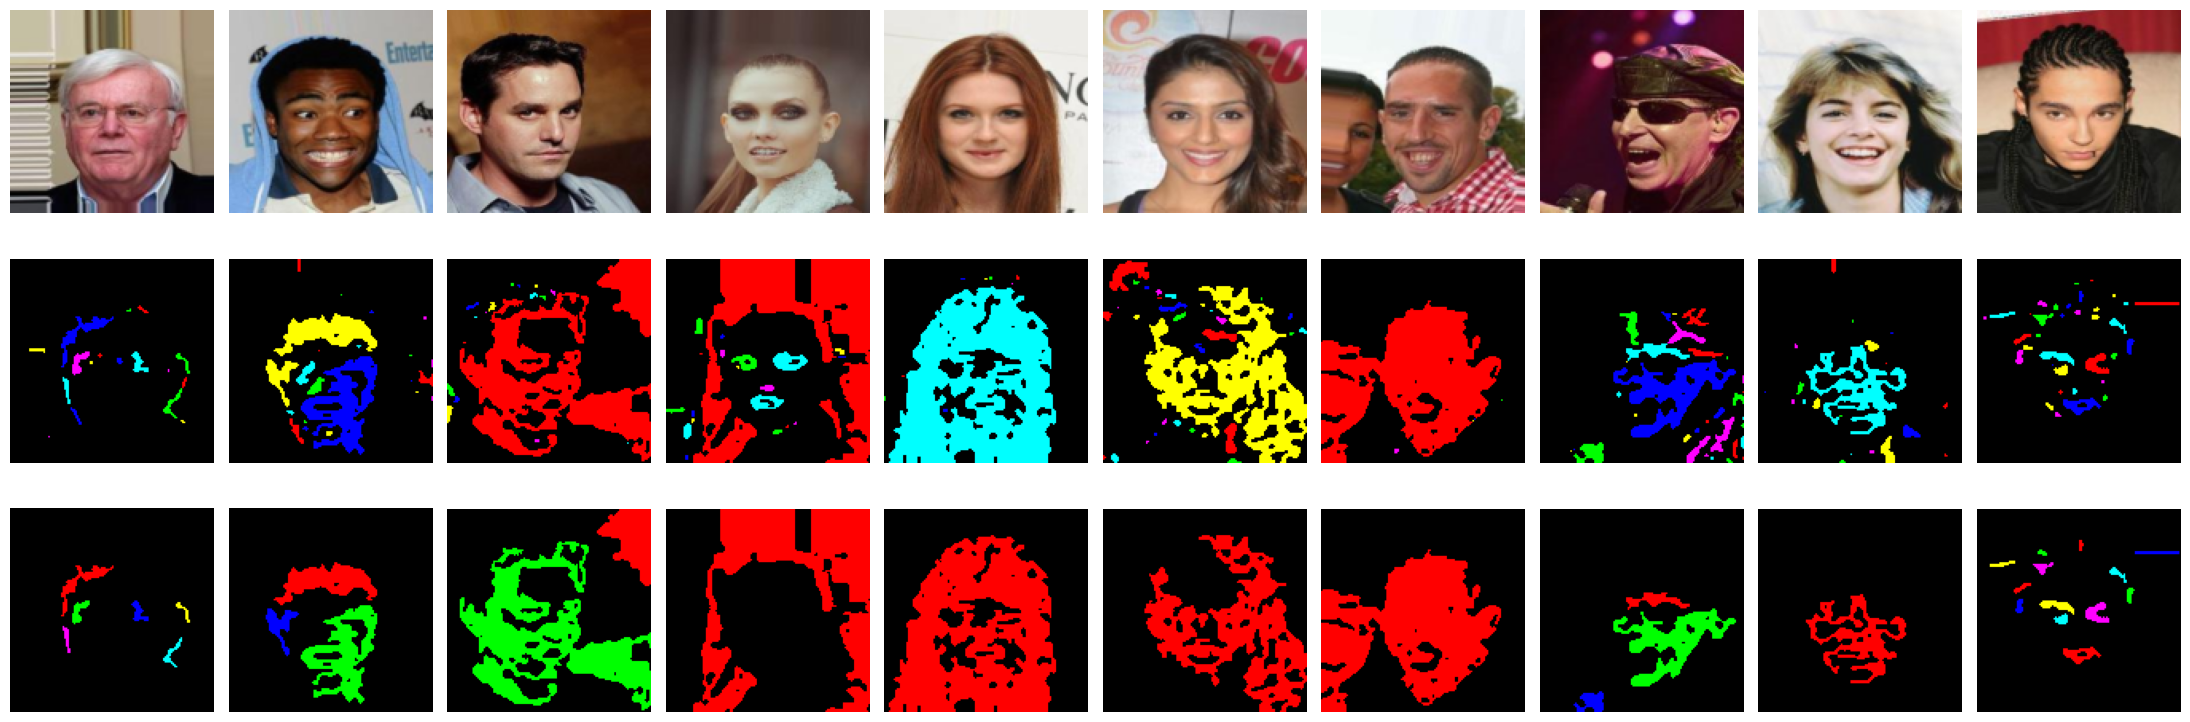

In [98]:
OUT_DIR = "./outputs"
analyze_celeba(dataset, OUT_DIR, num_images=10)

### Ellipse Fitting

In [3]:
class Ellipse(NamedTuple):
    """Represents an ellipse with center (h,k) and radius (rx,ry)."""
    h: float  # center x-coordinate
    k: float  # center y-coordinate
    rx: float # x-radius
    ry: float # y-radius
    
    def contains(self, x: float, y: float) -> bool:
        """Check if point (x,y) lies inside the ellipse."""
        return (x-self.h)**2 / self.rx**2 + (y-self.k)**2 / self.ry**2 <= 1

def fit_ellipse(comp: List[np.ndarray]) -> Ellipse:
    """Fit an ellipse to points using direct least squares method."""
    x = np.asarray(comp)[:, 0][:, None]
    y = np.asarray(comp)[:, 1][:, None]
    
    D = np.hstack([x*x, x*y, y*y, x, y, np.ones(x.shape)])
    
    C = np.zeros([6, 6])
    C[0, 2] = C[2, 0] = 2
    C[1, 1] = -1
    
    try:
        E, V = np.linalg.eig(np.dot(np.linalg.inv(np.dot(D.T, D)), C))
        v = V[:, np.argmax(np.abs(E))]
        
        a, b, c, d, f, g = v[0], v[1]/2.0, v[2], v[3]/2.0, v[4]/2, v[5]
        num = b*b - a*c
        
        if abs(num) < 1e-10:  # Prevent division by zero
            return None
            
        h = (c*d - b*f) / num
        k = (a*f - b*d) / num
        
        up = 2 * (a*f*f + c*d*d + g*b*b - 2*b*d*f - a*c*g)
        down1 = num * ((c-a) * np.sqrt(1 + 4*b*b / ((a-c)**2 + 1e-10)) - (c+a))
        down2 = num * ((a-c) * np.sqrt(1 + 4*b*b / ((a-c)**2 + 1e-10)) - (c+a))
        
        if down1 == 0 or down2 == 0:
            return None
            
        rx = 2 * np.sqrt(abs(up / down1))
        ry = 2 * np.sqrt(abs(up / down2))
        
        return Ellipse(h=h, k=k, rx=rx, ry=ry)
    except:
        return None

def generate_random_ellipse(comp: List[np.ndarray]) -> Ellipse:
    """Generate a random ellipse based on component bounds."""
    xs = np.asarray(comp)[:, 0]
    ys = np.asarray(comp)[:, 1]
    
    return Ellipse(
        h=random.choice(xs),
        k=random.choice(ys),
        rx=0.01 + random.random() * ((xs.max() - xs.min()) / 2),
        ry=0.01 + random.random() * ((ys.max() - ys.min()) / 2),
    )

def color_ellipses(img: np.ndarray, ellipses: List[Ellipse], overlay_color: np.ndarray) -> np.ndarray:
    """Visualize ellipses on image with overlay color."""
    if not ellipses:
        return img.copy()
        
    colored = img.astype(np.float32)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if any(e and e.contains(x, y) for e in ellipses):
                colored[x, y] += overlay_color
    
    return np.clip(colored, 0, 255).astype(np.uint8)

def analyze_celeba_faces(dataset, output_dir: str, num_images: int = 5):
    """Analyze CelebA faces with connected components and ellipse fitting."""

    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # Setup visualization
    fig, axes = plt.subplots(num_images, 6, figsize=(28, 6 * num_images))
    plt.rcParams.update({'font.size': 14})
    
    OVERLAY = 0.65 * np.array([-169, 255, -169])  # Green overlay
    TRIES = 90  # Number of random ellipse attempts
    
    for idx, img_idx in enumerate(indices):
        # Load and process image
        img_tensor, _ = dataset[img_idx]
        img = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        
        # Get face components
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hue = hsv[:, :, 0] / hsv[:, :, 0].max()
        mask = (0.02 <= hue) & (hue <= 0.06)
        mask = cv2.medianBlur(mask.astype(np.float32), ksize=3).astype(bool)
        
        # Find connected components
        def flood_fill(r, c):
            if not mask[r, c]:
                return []
            stack = [(r, c)]
            comp = []
            mask[r, c] = False
            while stack:
                cr, cc = stack.pop()
                comp.append((cr, cc))
                for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                    nr, nc = cr + dr, cc + dc
                    if (0 <= nr < mask.shape[0] and 
                        0 <= nc < mask.shape[1] and 
                        mask[nr, nc]):
                        stack.append((nr, nc))
                        mask[nr, nc] = False
            return comp
            
        components = []
        for r in range(mask.shape[0]):
            for c in range(mask.shape[1]):
                if mask[r, c]:
                    comp = flood_fill(r, c)
                    if len(comp) > 50:  # Filter small components
                        components.append(np.array(comp))
        
        # Fit ellipses
        precise_ellipses = [fit_ellipse(comp) for comp in components]
        random_ellipses = []
        for comp in components:
            best_ellipse = None
            best_score = float('-inf')
            for _ in range(TRIES):
                ellipse = generate_random_ellipse(comp)
                score = sum(1 for p in comp if ellipse.contains(p[0], p[1]))
                if score > best_score:
                    best_score = score
                    best_ellipse = ellipse
            random_ellipses.append(best_ellipse)
        
        # Visualize results
        titles = [
            'Original image',
            f'Components ({len(components)})',
            'Random ellipses (separate)',
            'Precise ellipses (separate)',
            'Random ellipses (combined)',
            'Precise ellipses (combined)'
        ]
        
        for ax, title in zip(axes[idx], titles):
            ax.set_title(title)
            ax.axis('off')
        
        # Plot results
        axes[idx, 0].imshow(img)
        
        # Color components
        comp_img = img.copy()
        colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)]
        for comp, color in zip(components, colors):
            comp_img[comp[:,0], comp[:,1]] = color
        axes[idx, 1].imshow(comp_img)
        
        # Plot ellipses
        axes[idx, 2].imshow(color_ellipses(img, random_ellipses, OVERLAY))
        axes[idx, 3].imshow(color_ellipses(img, precise_ellipses, OVERLAY))
        
        # Combined ellipses
        if components:
            all_points = np.vstack(components)
            combined_random = generate_random_ellipse(all_points)
            combined_precise = fit_ellipse(all_points)
            
            axes[idx, 4].imshow(color_ellipses(img, [combined_random], OVERLAY))
            axes[idx, 5].imshow(color_ellipses(img, [combined_precise], OVERLAY))
    
    plt.tight_layout()
    
    # Save results
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'face_analysis.jpg'), bbox_inches='tight')

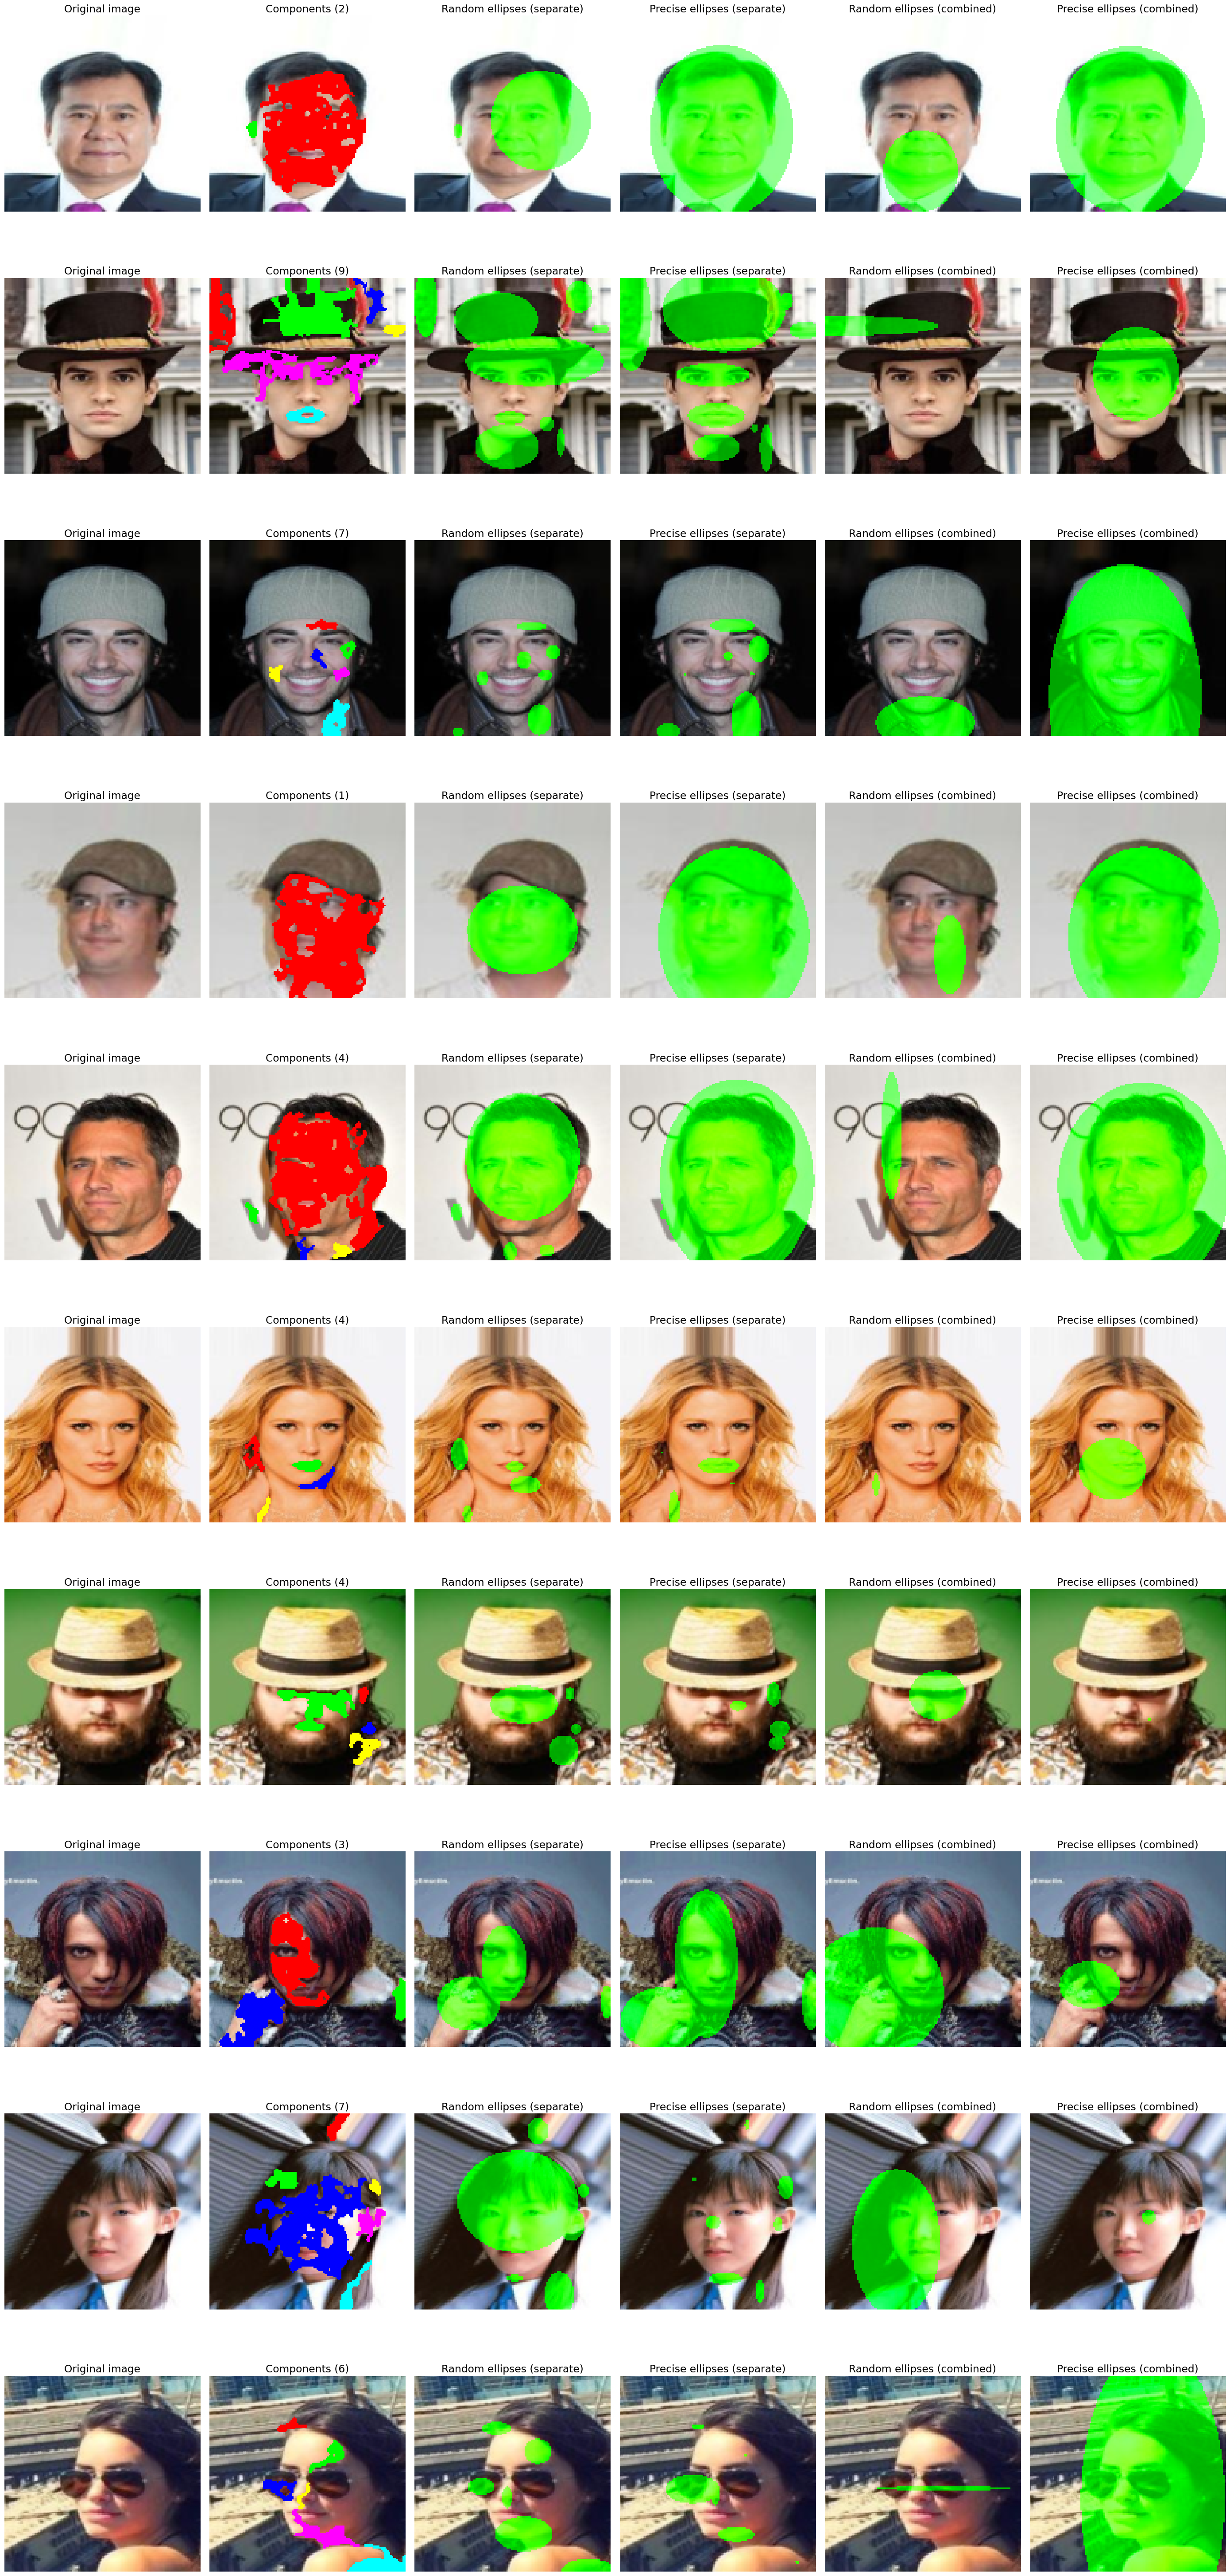

In [7]:
analyze_celeba_faces(
    dataset,
    output_dir="./outputs",
    num_images=10
)